In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Android_Malware.csv', index_col=0)

/var/folders/rl/dnlq62k50fd_dd8959xr62nh0000gn/T/ipykernel_23686/3584906996.py:1: DtypeWarning: Columns (56,58,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Android_Malware.csv', index_col=0)


## Initial EDA
### Data Integrity Inspection

In [3]:
data.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.217.6.202-10.42.0.211-443-50004-6,10.42.0.211,50004,172.217.6.202,443.0,6.0,13/06/2017 11:52:39,37027,1,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
1,172.217.6.202-10.42.0.211-443-35455-6,10.42.0.211,35455,172.217.6.202,443.0,6.0,13/06/2017 11:52:39,36653,1,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
2,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,13/06/2017 11:52:42,534099,8,12,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
3,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,13/06/2017 11:52:43,9309,3,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
4,131.253.61.68-10.42.0.211-443-51776-6,10.42.0.211,51776,131.253.61.68,443.0,6.0,13/06/2017 11:52:42,19890496,8,6,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware


In [6]:
d = data.sample(10)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355630 entries, 0 to 409
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       355629 non-null  object 
 1    Source IP                    355630 non-null  object 
 2    Source Port                  355630 non-null  int64  
 3    Destination IP               355630 non-null  object 
 4    Destination Port             355630 non-null  float64
 5    Protocol                     355630 non-null  float64
 6    Timestamp                    355630 non-null  object 
 7    Flow Duration                355630 non-null  int64  
 8    Total Fwd Packets            355630 non-null  int64  
 9    Total Backward Packets       355630 non-null  int64  
 10  Total Length of Fwd Packets   355630 non-null  float64
 11   Total Length of Bwd Packets  355630 non-null  float64
 12   Fwd Packet Length Max        355630 non-null  

### Removing Duplicates

In [8]:
data[data.duplicated()]

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
90,203.205.158.60-10.42.0.211-80-48574-6,203.205.158.60,80,10.42.0.211,48574.0,6.0,27/06/2017 02:23:49,4,2,0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Scareware
94,10.42.0.211-111.206.25.159-33521-80-6,111.206.25.159,80,10.42.0.211,33521.0,6.0,27/06/2017 02:23:49,8,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Scareware
438,10.42.0.211-106.39.169.66-38659-443-6,10.42.0.211,38659,106.39.169.66,443.0,6.0,27/06/2017 02:29:27,5,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Scareware
475,10.42.0.211-119.146.74.34-36805-80-6,119.146.74.34,80,10.42.0.211,36805.0,6.0,27/06/2017 02:29:30,10,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Scareware
476,10.42.0.211-119.146.74.48-33523-80-6,119.146.74.48,80,10.42.0.211,33523.0,6.0,27/06/2017 02:29:30,8,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Scareware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,10.42.0.211-118.178.143.65-50070-80-6,10.42.0.211,50070,118.178.143.65,80.0,6.0,30/06/2017 02:48:06,8769698,4,4,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
407,140.205.61.26-10.42.0.211-80-47648-6,10.42.0.211,47648,140.205.61.26,80.0,6.0,30/06/2017 02:48:17,892843,5,6,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
408,140.205.61.26-10.42.0.211-80-47648-6,10.42.0.211,47648,140.205.61.26,80.0,6.0,30/06/2017 02:48:18,109,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
409,10.42.0.211-121.41.62.82-44183-1088-6,10.42.0.211,44183,121.41.62.82,1088.0,6.0,30/06/2017 02:48:17,12192623,2,0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware


In [9]:
data = data.drop_duplicates()

### Data Sparcity checks

In [10]:
# If a column has only one unique value, it essentially does nothing from an ML standpoint and should be removed
data.columns[data.nunique()==1]

Index([' ECE Flag Count', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [11]:
# We drop the above columns from the data here
data = data.drop(columns=data.columns[data.nunique()==1])

In [12]:
# Percentage of each row that is unique
# Difficult to use this as a method of filtering based on the size of our data, as we see a lot of our categorical features have very low values
data.nunique()/len(data)*100

Flow ID              50.165133
 Source IP            0.718933
 Source Port         14.555274
 Destination IP       1.345448
 Destination Port     5.502275
                       ...    
Idle Mean            11.289458
 Idle Std             2.519384
 Idle Max            11.279820
 Idle Min            11.278402
Label                 0.001134
Length: 79, dtype: float64

## Non-numerical Data Analysis

Much of our data seems to be numerical, but there are a few columns that are not numerical. Additionally, just looking at a glance, there are some columns that are numerical but cannot actually be interpreted as ordinal data (Destination Port, for example). Both of these have to be dealt with in different ways.

first of all, lets look at our object columns

In [16]:
data.select_dtypes(include='object')

,Flow ID,Source IP,Destination IP,Timestamp,CWE Flag Count,Down/Up Ratio,Fwd Avg Bytes/Bulk,Label
0,172.217.6.202-10.42.0.211-443-50004-6,10.42.0.211,172.217.6.202,13/06/2017 11:52:39,0,1.0,0,Android_Adware
1,172.217.6.202-10.42.0.211-443-35455-6,10.42.0.211,172.217.6.202,13/06/2017 11:52:39,0,1.0,0,Android_Adware
2,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,131.253.61.68,13/06/2017 11:52:42,0,1.0,0,Android_Adware
3,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,131.253.61.68,13/06/2017 11:52:43,0,0.0,0,Android_Adware
4,131.253.61.68-10.42.0.211-443-51776-6,10.42.0.211,131.253.61.68,13/06/2017 11:52:42,0,0.0,0,Android_Adware
...,...,...,...,...,...,...,...,...
405,172.217.7.14-10.42.0.211-80-38405-6,172.217.7.14,10.42.0.211,17/06/2017 01:29:11,0,1.0,0,Benign
406,10.42.0.211-10.42.0.1-7632-53-17,10.42.0.211,10.42.0.1,17/06/2017 01:30:33,0,1.0,0,Benign
407,10.42.0.211-104.192.110.245-45970-443-6,10.42.0.211,104.192.110.245,17/06/2017 01:29:45,0,0.0,0,Benign
408,10.42.0.211-10.42.0.1-51982-53-17,10.42.0.211,10.42.0.1,17/06/2017 01:29:45,0,1.0,0,Benign


### Dealing with object cols that should be numerical

Here we can already see that there are a few columns that don't seem to belong here, namely `CWE Flag Count`, `Down/Up Ratio`, and `Fwd Avg Bytes/Bulk`


In [18]:
# this column seems to encode 0 in a few different ways and also has a seperate SCAREWARE label that does not make sense in this context
# We have no real way to clean this, so it should be dropped
data[' CWE Flag Count'].unique()

array([0, nan, '0', 'SCAREWARE'], dtype=object)

In [44]:
# This column seems like it should be numerically interpretable, but has a few issues with the encoding. Some intergers are strings, and there is an out of place BENIGN label again
# This can be cleaned manually
data[' Down/Up Ratio'].unique()

array([1, 0, 2, 3, 8, 4, 5, 9, 6, 12, 7, 10, 11, <NA>, 75], dtype=object)

In [49]:
# cleaning Down/Up Ratio
data.loc[data[' Down/Up Ratio'] == 'BENIGN', ' Down/Up Ratio'] = pd.NA
data[' Down/Up Ratio'] = data[' Down/Up Ratio'].apply(lambda x: int(x) if not pd.isna(x) else pd.NA)
data[' Down/Up Ratio'] = data[' Down/Up Ratio'].astype('Int64')

In [50]:
# similar to CWE Flag Count, this is just varying flavors of 0/null with an out of place BENIGN lable
# will also be dropped
data['Fwd Avg Bytes/Bulk'].unique()

array([0, '0', 'BENIGN', '0.0', nan], dtype=object)

In [51]:
# drop the two unconvertable columns
data = data.drop(columns=['Fwd Avg Bytes/Bulk', ' CWE Flag Count'])

### Dealing with true object columns

Now we have to deal with our non-numerical inputs, the most important of which is likely to be the IP adress of the traffic. There are many ways we can go about converting these into numerical features, but the first we will try is simply splitting at the period and encoding each section as a different numerical column. Even these seperate components cannot be interpreted in an ordinal manner, so we will likely have to have to encode them as one-hot categorical columns to treat them properly

In [52]:
# Flow ID seems to be derivative of other columns and can be dropped as it adds no new information (just destination ip - source ip - timestamp)
data['Flow ID']

0        172.217.6.202-10.42.0.211-443-50004-6
1        172.217.6.202-10.42.0.211-443-35455-6
2        131.253.61.68-10.42.0.211-443-51775-6
3        131.253.61.68-10.42.0.211-443-51775-6
4        131.253.61.68-10.42.0.211-443-51776-6
                        ...                   
405        172.217.7.14-10.42.0.211-80-38405-6
406           10.42.0.211-10.42.0.1-7632-53-17
407    10.42.0.211-104.192.110.245-45970-443-6
408          10.42.0.211-10.42.0.1-51982-53-17
409           10.42.0.211-10.42.0.1-9320-53-17
Name: Flow ID, Length: 355630, dtype: object

In [75]:
# these rows are very broken
data[data[' Source IP'].str.count('\.') < 3]

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


In [81]:
data[data[" Source IP"].str.count("\.") < 3].index


Int64Index([], dtype='int64')

In [80]:
data[data[" Destination IP"].str.count("\.") < 3].index


Int64Index([], dtype='int64')

In [74]:
data = data.drop(labels=data[data[" Source IP"].str.count("\.") < 3].index, axis=0)


In [79]:
data[["source_ip_1", "source_ip_2", "source_ip_3", "source_ip_4"]] = data[
    " Source IP"
].str.split(".", expand=True)


In [82]:
data[
    ["destination_ip_1", "destination_ip_2", "destination_ip_3", "destination_ip_4"]
] = data[" Destination IP"].str.split(".", expand=True)


In [85]:
data[
    [
        "destination_ip_1",
        "destination_ip_2",
        "destination_ip_3",
        "destination_ip_4",
        "source_ip_1",
        "source_ip_2",
        "source_ip_3",
        "source_ip_4",
    ]
] = data[
    [
        "destination_ip_1",
        "destination_ip_2",
        "destination_ip_3",
        "destination_ip_4",
        "source_ip_1",
        "source_ip_2",
        "source_ip_3",
        "source_ip_4",
    ]
].astype(
    "Int32"
)


### Dealing with numerical columns that should be treated as object columns (classes)

There are many rows and a few columns that are considered categoricals, so we don't want to just use the percentage of unique values per column as a deciding factor. Instead, we have to take into account the percent contribution of each unique value to each column. For example, if a column has 4 unique labels but one label takes up 99.9% of the rows, it likely does not add much modeling capability.

We can use a variance threshold to take care of numerical features that are highly sparse. This can be visualized by plotting change in selected features vs variance threshold, as we do below

In [13]:
from sklearn.feature_selection import VarianceThreshold

data_num = data.select_dtypes(exclude='object')

x_eda = data_num.iloc[:, :-1] # Take until the last column
y_eda = data_num.iloc[:, -1] # Take the last column

transform = VarianceThreshold()

variance_thresholds = np.arange(start=0.0, stop=0.5, step=0.05)

results = []

for t in variance_thresholds:
    
    transform = VarianceThreshold(threshold=t)
    
    X_sel = transform.fit_transform(x_eda)
    print()
    rows, cols = X_sel.shape
    n_features = cols
    print('Threshold=%.2f, Features=%d' % (t, n_features))
    
    results.append(n_features)
    
d2 = pd.DataFrame({'threshold': variance_thresholds, 'n_features': results})
alt.Chart(d2).mark_line().encode(
    x='threshold',
    y='n_features')


Threshold=0.00, Features=70

Threshold=0.05, Features=68

Threshold=0.10, Features=68

Threshold=0.15, Features=67

Threshold=0.20, Features=66

Threshold=0.25, Features=64

Threshold=0.30, Features=64

Threshold=0.35, Features=64

Threshold=0.40, Features=64

Threshold=0.45, Features=64


alt.Chart(...)

Using a variance threshold to filter features does not do much to narrow things down in this case, focusing on only our numerical features. As stated above, we need to use a different approach to deal with sparse categorical features

### Checking for outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x2bae5f160>,
 'caps': [<matplotlib.lines.Line2D at 0x2bae5f6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2bae37d30>],
 'medians': [<matplotlib.lines.Line2D at 0x2bae5fbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2bae5fe80>],
 'means': []}

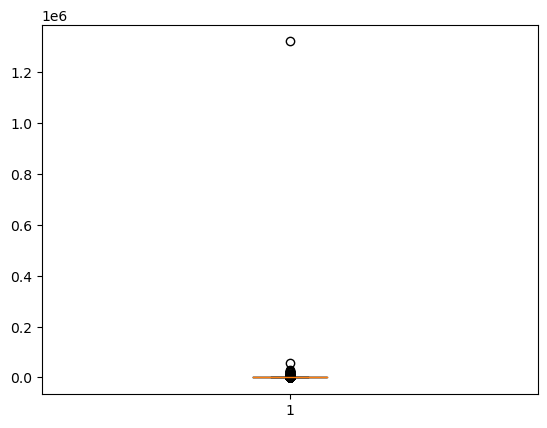

In [14]:
plt.boxplot(data[' Total Backward Packets'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2baf41fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x2baf51520>,
 'boxes': [<matplotlib.lines.Line2D at 0x2baf41c40>],
 'medians': [<matplotlib.lines.Line2D at 0x2baf51a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x2baf51d00>],
 'means': []}

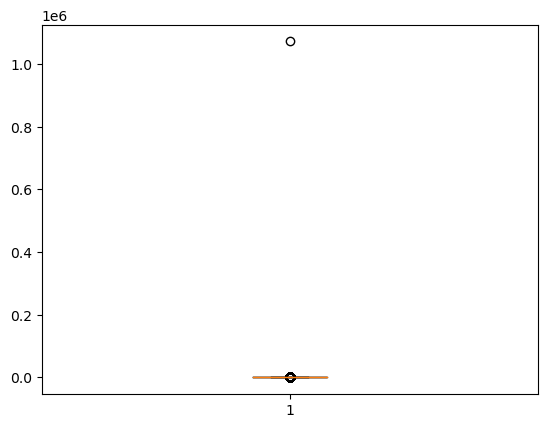

In [15]:
plt.boxplot(data[' Fwd Packet Length Max'])

In [16]:
def count_outliers(data):
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    return len(outliers)

In [17]:
count_outliers(data[' Fwd Packet Length Max'])

27617

In [18]:
for i in range(len(data.columns)):
    try:
        if count_outliers(data.iloc[:,i])>0:
            print(data.columns[i],":",count_outliers(data.iloc[:,i]))
    except:
        continue

 Source Port : 44853
 Destination Port : 45186
 Protocol : 78330
 Flow Duration : 48222
 Total Fwd Packets : 37357
 Total Backward Packets : 40319
Total Length of Fwd Packets : 47050
 Total Length of Bwd Packets : 74730
 Fwd Packet Length Max : 27617
 Fwd Packet Length Min : 10516
 Fwd Packet Length Mean : 43532
 Fwd Packet Length Std : 41442
Bwd Packet Length Max : 69790
 Bwd Packet Length Min : 75644
 Bwd Packet Length Mean : 57790
 Bwd Packet Length Std : 70423
Flow Bytes/s : 56953
 Flow Packets/s : 62361
 Flow IAT Mean : 47625
 Flow IAT Std : 64917
 Flow IAT Max : 47051
 Flow IAT Min : 65336
Fwd IAT Total : 52046
 Fwd IAT Mean : 58997
 Fwd IAT Std : 70052
 Fwd IAT Max : 55330
 Fwd IAT Min : 76128
Bwd IAT Total : 65948
 Bwd IAT Mean : 70531
 Bwd IAT Std : 70783
 Bwd IAT Max : 64914
 Bwd IAT Min : 65283
Fwd PSH Flags : 23034
 Bwd PSH Flags : 1
 Fwd URG Flags : 1
 Bwd URG Flags : 2
 Fwd Header Length : 49914
 Bwd Header Length : 45396
Fwd Packets/s : 63032


In [20]:
# Checking the balance of the output variable
data['Label'].value_counts()

Android_Adware         147443
Android_Scareware      117070
Android_SMS_Malware     64524
Benign                  23708
Name: Label, dtype: int64

In [21]:
# Finding null values per column
data.isna().sum()[data.isna().sum() > 0]

Flow ID                     1
 Bwd Packets/s              1
 Min Packet Length          1
 Max Packet Length          1
 Packet Length Mean         1
 Packet Length Std          1
 Packet Length Variance     1
FIN Flag Count              1
 SYN Flag Count             1
 RST Flag Count             1
 PSH Flag Count             1
 ACK Flag Count             1
 URG Flag Count             1
 CWE Flag Count             1
 Down/Up Ratio              2
 Average Packet Size        3
 Avg Fwd Segment Size       3
 Avg Bwd Segment Size       3
 Fwd Header Length.1        3
Fwd Avg Bytes/Bulk          3
Subflow Fwd Packets         4
 Subflow Fwd Bytes          4
 Subflow Bwd Packets        4
 Subflow Bwd Bytes          4
Init_Win_bytes_forward      4
 Init_Win_bytes_backward    4
 act_data_pkt_fwd           4
 min_seg_size_forward       4
Active Mean                 4
 Active Std                 4
 Active Max                 4
 Active Min                 4
Idle Mean                   4
 Idle Std 

In [22]:
data = data.dropna()

In [23]:
list(data.select_dtypes(exclude=np.dtype('object')).columns) + ['Label']

[' Source Port',
 ' Destination Port',
 ' Protocol',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 'Fwd PSH Flags',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' SYN Flag C

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

rfc = RandomForestClassifier(n_jobs=-1)

# The data is not yet clean, so we will use just the numerical data as a worst-case-scenario baseline

data_num = data[list(data.select_dtypes(exclude=np.dtype('object')).columns) + ['Label']]

X = data_num.drop(columns='Label')
Y = data_num['Label']

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, random_state=1)


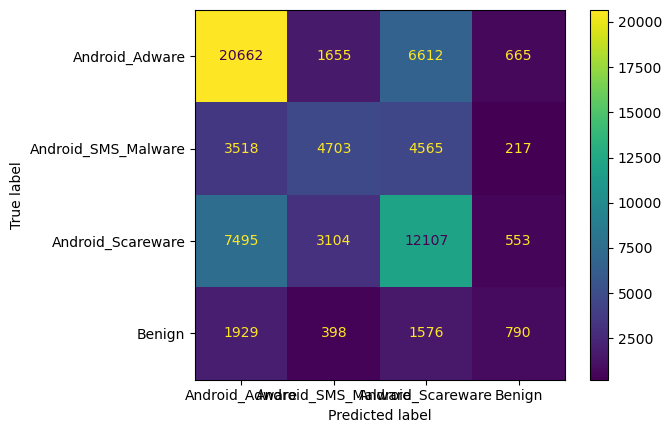

In [27]:
rfc.fit(x_train, y_train)

ConfusionMatrixDisplay.from_estimator(rfc, x_val, y_val)

plt.show()

Initial results seem poor, likely due to a painfully unbalanced dataset, among other factors. Due to the volume of data availible, balancing will be a simple as downsampling the positive classes to fall in line with the benign class. In an actual model use case, a higher false positive rate will be beneficial as with most antivirus solutions.